In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr


c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import creep data
creep_df = pd.read_csv('../Data/SS316_dataset.csv')
creep_df


,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,Ti,Al,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,creep_rupture_life
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,0.0110,0.015,0.0010,0.0300,0.020,55,61,235,650,29.2
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,0.0110,0.018,0.0005,0.0340,0.010,68,78,157,700,34.5
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,0.0600,0.020,0.0008,0.0318,0.010,72,77,235,650,38.8
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,0.0006,0.011,0.0010,0.0810,0.001,106,80,177,700,39.0
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,0.0290,0.021,0.0007,0.0224,0.010,75,83,157,700,40.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,0.0600,0.020,0.0008,0.0318,0.010,41,55,118,600,142185.9
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,0.0430,0.017,0.0011,0.0250,0.010,26,39,108,600,152758.0
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,0.0550,0.027,0.0013,0.0350,0.020,28,37,108,600,173814.3
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,0.0430,0.017,0.0011,0.0250,0.010,25,23,41,700,178190.4


In [3]:
Log_Creep_Life = np.log10(creep_df['creep_rupture_life'])
creep_df['Log_Creep_Life'] = Log_Creep_Life
creep_df = creep_df.drop(columns = ['creep_rupture_life'])

In [4]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Material           617 non-null    int64  
 1   C                  617 non-null    float64
 2   Si                 617 non-null    float64
 3   Mn                 617 non-null    float64
 4   P                  617 non-null    float64
 5   S                  617 non-null    float64
 6   Ni                 617 non-null    float64
 7   Cr                 617 non-null    float64
 8   Mo                 617 non-null    float64
 9   Cu                 617 non-null    float64
 10  Ti                 617 non-null    float64
 11  Al                 617 non-null    float64
 12  B                  617 non-null    float64
 13  N                  617 non-null    float64
 14  Nb+Ta              617 non-null    float64
 15  Elongation         617 non-null    int64  
 16  Reduction of Area  617 non

In [5]:
features = creep_df.iloc[:, 0:19]
targets = creep_df.iloc[:, 19]
features

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,Ti,Al,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,0.0110,0.015,0.0010,0.0300,0.020,55,61,235,650
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,0.0110,0.018,0.0005,0.0340,0.010,68,78,157,700
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,0.0600,0.020,0.0008,0.0318,0.010,72,77,235,650
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,0.0006,0.011,0.0010,0.0810,0.001,106,80,177,700
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,0.0290,0.021,0.0007,0.0224,0.010,75,83,157,700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,0.0600,0.020,0.0008,0.0318,0.010,41,55,118,600
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,0.0430,0.017,0.0011,0.0250,0.010,26,39,108,600
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,0.0550,0.027,0.0013,0.0350,0.020,28,37,108,600
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,0.0430,0.017,0.0011,0.0250,0.010,25,23,41,700


In [6]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run #  1 Fold # 1
Pearson CC: 0.9901149365506309
R2 score: 0.978785353064606
RMSE: 0.12979453802108765
MAE: 0.09948813170194626
Coverage: 87.90322580645163
Interval Width: 0.442085862159729
Composite Metric: 1.2247752000240775


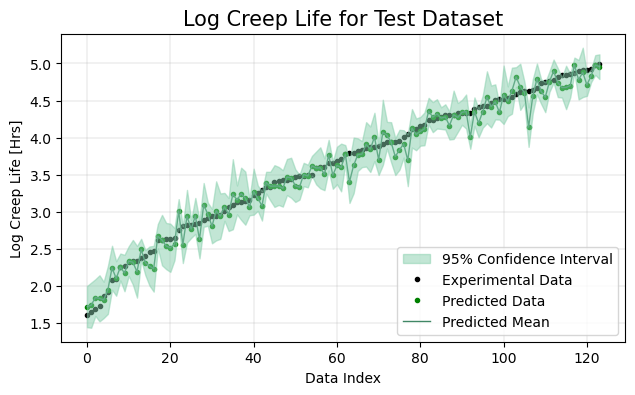

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run #  1 Fold # 2
Pearson CC: 0.9908714580362692
R2 score: 0.9816352354752208
RMSE: 0.12569621205329895
MAE: 0.08936569839715958
Coverage: 80.64516129032259
Interval Width: 0.26355302333831787
Composite Metric: 1.553414433959967


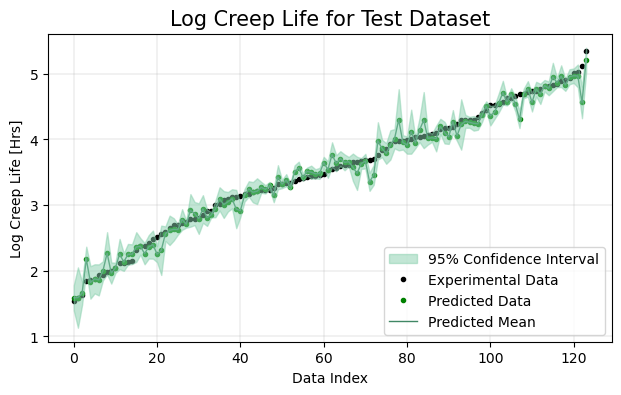

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run #  1 Fold # 3
Pearson CC: 0.9932858537569236
R2 score: 0.9864134376931647
RMSE: 0.10948783904314041
MAE: 0.07916601002216339
Coverage: 90.24390243902435
Interval Width: 0.3124547004699707
Composite Metric: 1.4769452519023671


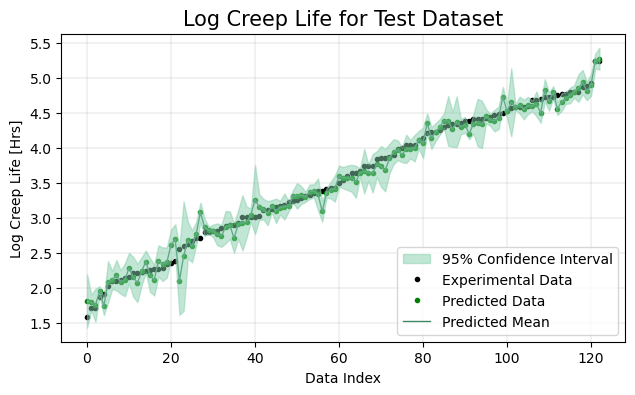

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run #  1 Fold # 4
Pearson CC: 0.9917959865368321
R2 score: 0.981676747449556
RMSE: 0.11673077195882797
MAE: 0.08691956847906113
Coverage: 82.92682926829265
Interval Width: 0.29810190200805664
Composite Metric: 1.4605906187108064


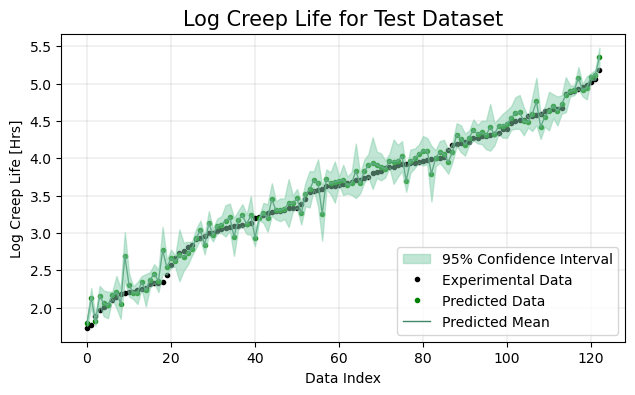

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run #  1 Fold # 5
Pearson CC: 0.9936248351406907
R2 score: 0.9860613600952706
RMSE: 0.10380174964666367
MAE: 0.08169418573379517
Coverage: 86.17886178861785
Interval Width: 0.3252449035644531
Composite Metric: 1.4149930157070068


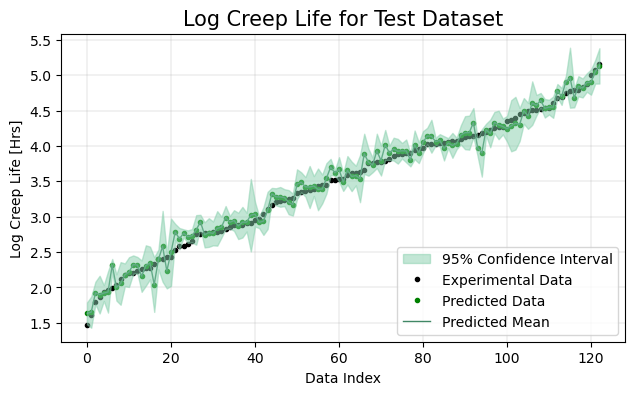

In [7]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)


for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=19, output_dim=1, hidden_dim=100, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.5)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            ensemble_size = 5
            ensemble = [MLP(hidden_dim=10, n_hidden_layers=3) for _ in range(ensemble_size)]

            for net in ensemble:
                  train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_preds = [np.array(net(torch.Tensor(x_test)).clone().detach().numpy()) for net in ensemble]
            # mean and standard deviation
            y_pred = np.mean(np.array(y_preds), axis=0)
            y_std = np.std(np.array(y_preds), axis=0)


            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std


            test_coverage[j, i] = coverage(y_test_np, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')


            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])
          


            plt.show()

In [8]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.990115,0.978785,0.129795,0.099488
1,0.990871,0.981635,0.125696,0.089366
2,0.993286,0.986413,0.109488,0.079166
3,0.991796,0.981677,0.116731,0.086920
4,0.993625,0.986061,0.103802,0.081694


In [9]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.991939,0.001352,0.982914,0.002911,0.117102,0.009695,0.087327,0.007079


In [10]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,87.903226,0.442086,1.224775
1,80.645161,0.263553,1.553414
2,90.243902,0.312455,1.476945
3,82.926829,0.298102,1.460591
4,86.178862,0.325245,1.414993


In [11]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,85.579596,3.432199,0.328288,0.060517,1.426144,0.110126
